In [1]:
import numpy as np
import scipy.io as sio 
import os
import cv2
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz

--2022-11-15 08:23:45--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  19.6MB/s    in 54s     

2022-11-15 08:24:39 (17.4 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [3]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz

--2022-11-15 08:24:39--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  20.8MB/s    in 76s     

2022-11-15 08:25:56 (12.3 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [4]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_annos.mat

--2022-11-15 08:25:56--  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘cars_annos.mat’

cars_annos.mat      100%[===================>] 385.23K   284KB/s    in 1.4s    

2022-11-15 08:25:57 (284 KB/s) - ‘cars_annos.mat’ saved [394471/394471]



In [5]:
import tarfile
  
# open file
file = tarfile.open('cars_test.tgz')
# extracting file
file.extractall('/content/cars_dataset')
  
file.close()

In [6]:
import tarfile
  
# open file
file2 = tarfile.open('cars_train.tgz') 
# extracting file
file2.extractall('/content/cars_dataset')
  
file2.close()

In [7]:
os.listdir('/content/cars_dataset')

['cars_train', 'cars_test']

In [8]:
base_dir = '/content/cars_dataset'

In [9]:
def get_labels():
    annos = sio.loadmat('/content/cars_annos.mat')
    _, total_size = annos["annotations"].shape
    print("total sample size is ", total_size)
    labels = np.zeros((total_size, 5))
    for i in range(total_size):
        path = annos["annotations"][:,i][0][0][0].split(".")
        id = int(path[0][8:]) - 1
        for j in range(5):
            labels[id, j] = int(annos["annotations"][:,i][0][j + 1][0])
    return labels
labels = get_labels()

total sample size is  16185


image is 07654.jpg
orignal shape: 480 640
resized shape: 128 192


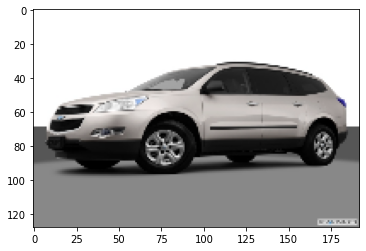

In [10]:
def peek_image(path, idx, labels):
    image_names = os.listdir(path + "")
    im = cv2.imread('/content/cars_dataset/cars_train/00010.jpg')
    print("image is", image_names[idx])
    name = image_names[idx].split('.')
    w, h, ch = im.shape
    print("orignal shape:" , w, h)
    h_resize = int(128*1.5)
    w_resize = 128
    im = cv2.resize(im,(h_resize,w_resize),interpolation=cv2.INTER_LINEAR)
    w, h, ch = im.shape
    print("resized shape:" , w, h)
    plt.imshow(im)

peek_image("/content/cars_dataset/cars_train", 4445, labels)   
labels = []

In [11]:
def read_data(path, labels):
    x = []
    y = []
    counter = 0
    
    for file in os.listdir('/content/cars_dataset/cars_test'):
        im = cv2.imread('/content/cars_dataset/cars_test/00010.jpg')
        name = file.split('.')
        w, h, ch = im.shape
        h_resize = int(128*1.5)
        w_resize = 128
        im = cv2.resize(im,(h_resize,w_resize),interpolation = cv2.INTER_LINEAR)
        x.append(im)
        y.append(labels[int(name[0]) - 1,4])
        if counter % 1000 == 0 and counter > 0:
            print("1000 images are loaded.")
        counter += 1
        #print(file, int(name[0]) - 1)
    return np.array(x), np.array(y).reshape([len(y),1])
        
def load_split_data():
    annos = sio.loadmat('/content/cars_annos.mat')
    _, total_size = annos["annotations"].shape
    print("total sample size is ", total_size)
    labels = np.zeros((total_size, 5))
    for i in range(total_size):
        path = annos["annotations"][:,i][0][0][0].split(".")
        id = int(path[0][8:]) - 1
        for j in range(5):
            labels[id, j] = annos["annotations"][:,i][0][j + 1][0]
    print("Annotation Loading completed.")
    x_train, y_train = read_data("cars_train", labels)
    print("Loading training data completed.")
    print("training dimension is",x_train.shape)
    x_val_test, y_val_test = read_data("cars_test", labels)
    val_test_size = x_val_test.shape[0]
    print("test and val dimension is",x_val_test.shape)
    print("Loading validation and test data completed.")
    
    #shuffle and splite vallidation data and test data
    p = np.random.permutation(val_test_size)
    x_val_test = x_val_test[p]
    y_val_test = y_val_test[p]
    x_val = x_val_test[0:int(val_test_size / 2),:,:,:]
    y_val = y_val_test[0:int(val_test_size / 2),:]
    print("validation size is",int(val_test_size / 2))
    x_test = x_val_test[int(val_test_size / 2):val_test_size,:,:,:]
    y_test = y_val_test[int(val_test_size / 2):val_test_size,:]
    print("test size is",val_test_size - int(val_test_size / 2))
    print("Spliting validation and test data completed.")
    return [x_train, x_val, x_test], [y_train, y_val, y_test]
X, Y = load_split_data()

total sample size is  16185
Annotation Loading completed.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
Loading training data completed.
training dimension is (8041, 128, 192, 3)
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
test and val dimension is (8041, 128, 192, 3)
Loading validation and test data completed.
validation size is 4020
test size is 4021
Spliting validation and test data completed.


In [12]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

img_path = '/content/cars_dataset/cars_test/00010.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

block4_pool_features = model.predict(x)

1/1 [==============================] - 1s 1s/step


In [13]:
block4_pool_features

array([[[[   0.       ,   99.78003  ,    0.       , ...,    0.       ,
             0.       ,  247.68494  ],
         [   0.       ,  110.41968  ,    0.       , ...,    0.       ,
             0.       ,  177.62535  ],
         [   0.       ,  298.16827  ,    0.       , ...,    0.       ,
             0.       ,  529.5879   ],
         ...,
         [   0.       ,    0.       ,    0.       , ...,    0.       ,
             0.       ,    0.       ],
         [   0.       ,    0.       ,    0.       , ...,    0.       ,
             0.       ,    0.       ],
         [   0.       ,  245.71265  ,    0.       , ...,    0.       ,
             0.       ,    0.       ]],

        [[   0.       ,   92.243645 ,    0.       , ...,  481.07584  ,
             0.       ,    6.2884207],
         [   0.       ,  159.48764  ,  182.55386  , ...,    0.       ,
             0.       ,    0.       ],
         [   0.       ,  234.43706  ,  236.2525   , ...,    0.       ,
             0.       ,   67.2187